### Setup

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt

## Testing

In [5]:


# get all the directories inside the data directory
data_dir = 'data'


data_files = os.listdir(data_dir)

print(data_files)

['Julian_straight_2_head 2024-06-07 14-10-08', 'Paul_circle_1_head 2024-06-07 13-51-26', 'Dany_circle_14_head 2024-06-07 15-27-29', 'Julian_straight_1_leg 2024-06-07 14-06-42', 'Mark_straight_14_head 15-42-49', 'Michele_circle_14_head 2024-06-07 15-54-09', 'Julian_straight_4_leg 2024-06-07 14-14-51', '.DS_Store', 'Julian_circle_14_leg 2024-06-07 15-30-46', 'Paul_straight_1_leg 2024-06-07 13-40-28', 'Paul_circle_4_leg 2024-06-07 13-58-19', 'Martin_straight_14_leg 2024-06-07 14-42-51', 'Julian_circle_14_head 2024-06-07 15-30-43', 'Dany_straight_14_leg 2024-06-07 15-22-52', 'Michele_straight_14_leg 2024-06-07 14-56-15', 'Paul_circle_4_head 2024-06-07 13-58-23', 'Martin_straight_14_leg 2024-06-07 14-42-51.zip', 'Dany_circle_14_leg 2024-06-07 15-27-49', 'Paul_straight_2_head 2024-06-07 13-45-59', 'Martin_circle_14_leg 2024-06-07 14-47-32', 'Paul_straight_2_leg 2024-06-07 13-46-08', 'Mark_circle_14_head 2024-06-07 15-47-53', 'Felix_circle_14_head 2024-06-07 15-11-05', 'Michele_circle_14_leg 

In [12]:
csv_files = os.listdir(os.path.join(data_dir, data_files[0]))

csv_files + (os.listdir(os.path.join(data_dir, data_files[0], 'meta')))


['Proximity.csv',
 'Light.csv',
 'meta',
 'Location.csv',
 'Magnetometer.csv',
 'Accelerometer.csv',
 'Gyroscope.csv',
 'Pressure.csv',
 'Linear Acceleration.csv',
 'device.csv']

### Reading the files

In [14]:

proximimity = pd.read_csv(os.path.join(data_dir, data_files[0], 'Proximity.csv'))

In [16]:
proximimity

,Time (s),Distance (cm)
0,0.093088,5.0


In [17]:
light = pd.read_csv(os.path.join(data_dir, data_files[0], 'Light.csv'))

In [22]:
light

,Time (s),Illuminance (lx)
0,0.000000,6796.897461
1,2.583698,13925.833010
2,5.124473,11944.293950
3,5.279810,10401.616210
4,6.295018,11919.097660
...,...,...
66,83.485936,17252.396480
67,83.735678,18806.412110
68,84.157363,20597.675780
69,84.570772,23010.001950


In [19]:
location = pd.read_csv(os.path.join(data_dir, data_files[0], 'Location.csv'))

In [21]:
location

,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (m)
0,0.696205,52.334870,4.868343,6.554244,0.000000,318.887695,3.805609,3.0
1,1.696123,52.334870,4.868343,6.495151,0.000000,318.887695,3.805638,3.0
2,2.696146,52.334870,4.868343,6.478753,0.000000,318.887695,3.805667,3.0
3,3.696154,52.334870,4.868343,6.329201,0.000000,318.887695,3.805696,3.0
4,4.696179,52.334870,4.868343,5.979173,0.000000,318.887695,3.805725,3.0
...,...,...,...,...,...,...,...,...
79,79.697310,52.334897,4.868337,1.273101,0.000000,306.650848,5.467105,3.0
80,80.697345,52.334897,4.868337,1.140938,0.000000,306.650848,3.770565,3.0
81,81.697398,52.334895,4.868341,1.095512,0.359804,306.650848,5.504813,3.0
82,82.697366,52.334896,4.868337,0.984683,0.000000,306.650848,5.037960,3.0


In [23]:
magnetometer = pd.read_csv(os.path.join(data_dir, data_files[0], 'Magnetometer.csv'))
magnetometer

,Time (s),Magnetic field x (µT),Magnetic field y (µT),Magnetic field z (µT)
0,0.043133,-204.618393,-19.141800,-8.881599
1,0.053137,-207.863602,-20.191000,-3.477000
2,0.063150,-211.230789,-22.106400,1.378600
3,0.073149,-215.390991,-23.460600,5.380200
4,0.083140,-220.344192,-24.412199,9.186600
...,...,...,...,...
8468,84.723138,-12.932000,-12.126800,-41.406799
8469,84.733150,-12.736800,-12.370800,-41.089600
8470,84.743126,-12.736800,-12.529400,-40.760201
8471,84.753136,-12.639200,-12.285399,-41.309200


In [25]:
accelerometer = pd.read_csv(os.path.join(data_dir, data_files[0], 'Accelerometer.csv')) 

accelerometer

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2)
0,0.016886,0.800997,4.600202,8.577073
1,0.018970,0.820140,4.619344,8.586644
2,0.021054,0.844068,4.648058,8.600403
3,0.023138,0.877568,4.671388,8.585447
4,0.025222,0.867996,4.676772,8.595019
...,...,...,...,...
39855,84.754072,-0.763310,4.028317,7.624131
39856,84.756200,-0.763909,3.952345,7.697112
39857,84.758328,-0.735793,3.914060,7.741379
39858,84.760451,-0.769292,3.818347,7.733005


In [30]:
accelerometer.columns

Index(['Time (s)', 'Acceleration x (m/s^2)', 'Acceleration y (m/s^2)',
       'Acceleration z (m/s^2)'],
      dtype='object')

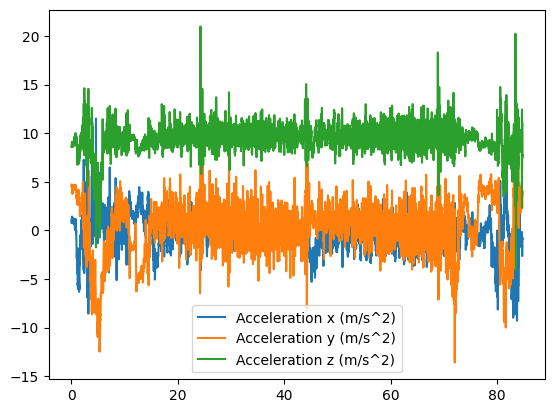

In [32]:
# plot the accelerometer data
import matplotlib.pyplot as plt

time_col = 'Time (s)'

value_col = accelerometer.columns[1:]

# plot all the value series in the same plot

for col in value_col:
    plt.plot(accelerometer[time_col], accelerometer[col], label=col)

plt.legend()

plt.show()




In [27]:
gyroscope = pd.read_csv(os.path.join(data_dir, data_files[0], 'Gyroscope.csv'))
gyroscope

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
0,0.029460,-0.014661,-0.035277,0.012523
1,0.031585,-0.021991,-0.035277,0.011301
2,0.033710,-0.029474,-0.036499,0.012523
3,0.035837,-0.030696,-0.037568,0.013744
4,0.037963,-0.035583,-0.041233,0.013897
...,...,...,...,...
39849,84.754072,-0.007178,0.011454,0.043677
39850,84.756200,-0.025656,0.007789,0.025351
39851,84.758328,-0.041539,0.005192,0.007178
39852,84.760451,-0.057421,-0.002291,-0.013592


In [28]:
pressure = pd.read_csv(os.path.join(data_dir, data_files[0], 'Pressure.csv'))

pressure

,Time (s),Pressure (hPa)
0,0.083742,1017.731384
1,0.108795,1017.746643
2,0.133861,1017.768005
3,0.158914,1017.768005
4,0.183968,1017.734436
...,...,...
3376,84.662247,1017.741089
3377,84.687300,1017.725830
3378,84.712353,1017.710571
3379,84.737419,1017.701416


In [29]:
linear_acceleration = pd.read_csv(os.path.join(data_dir, data_files[0], 'Linear Acceleration.csv'))

linear_acceleration

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2)
0,0.150661,0.046963,-0.279233,0.163260
1,0.167669,-0.068227,-0.538594,0.227133
2,0.184679,-0.210779,-0.512634,0.162561
3,0.201687,-0.283404,-0.270334,-0.008584
4,0.218693,-0.199914,-0.146165,-0.108453
...,...,...,...,...
4970,84.686069,0.466587,0.790668,-2.219433
4971,84.703060,-0.495235,-0.044745,-0.160688
4972,84.720055,-1.227224,-0.952751,1.294378
4973,84.737066,-0.430744,-0.105670,0.075890


### Plotting

In [3]:
# function to plot the data of the specified sensors and directory

def plot_sensor_data(csv_path):
    sensor_data = pd.read_csv(csv_path)
    time_col = 'Time (s)'
    value_col = sensor_data.columns[1:]
    for col in value_col:
        plt.plot(sensor_data[time_col], sensor_data[col], label=col)
    plt.legend()

    sensor_name = os.path.basename(csv_path).split('.')[0]
    plt.title(sensor_name)
    plt.show()

In [4]:
# function to get all the csv files paths in the specified directory

def get_csv_files(dir_path):
    csv_files = os.listdir(dir_path)
    csv_files = [os.path.join(dir_path, f) for f in csv_files if f.endswith('.csv')]
    return csv_files

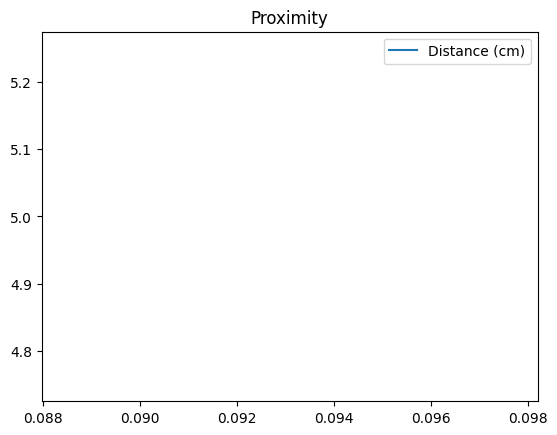

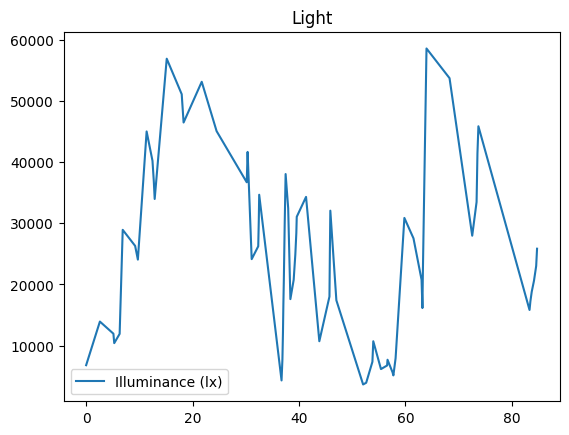

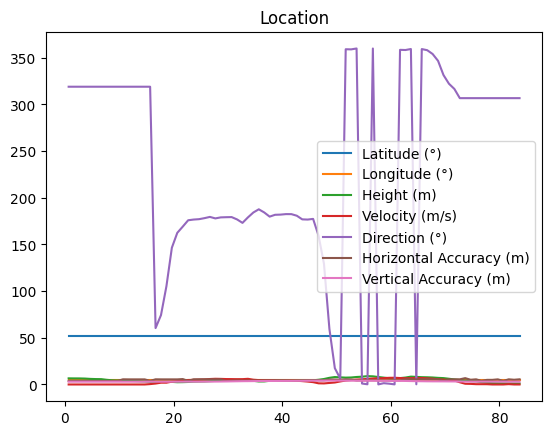

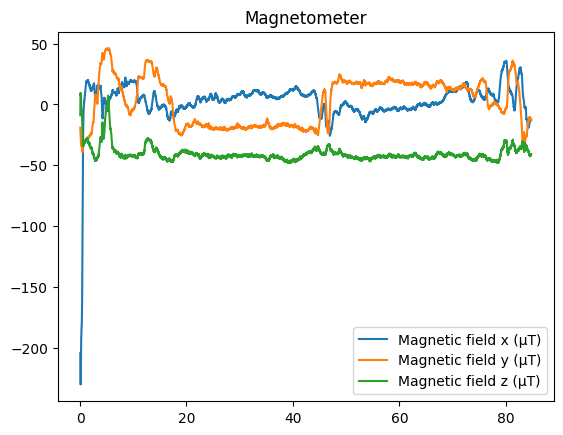

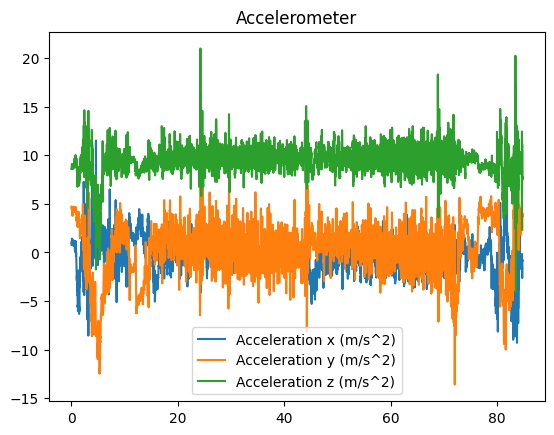

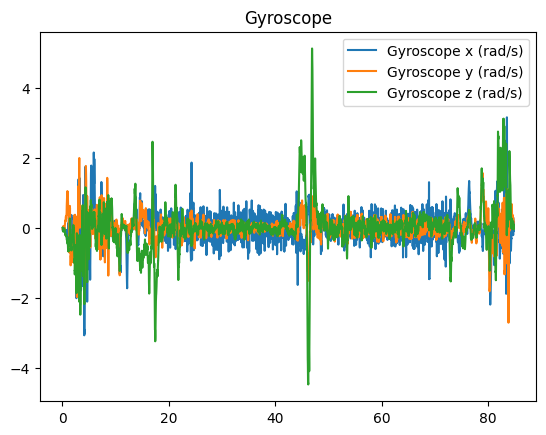

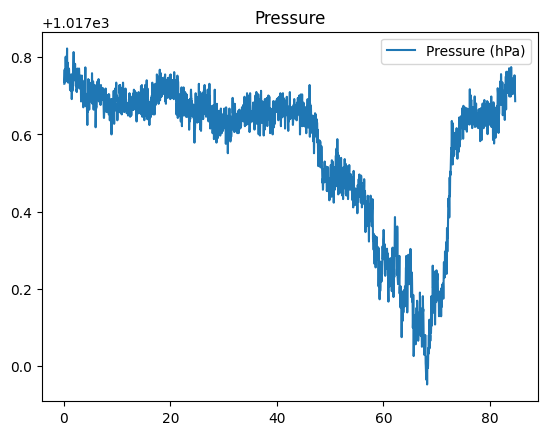

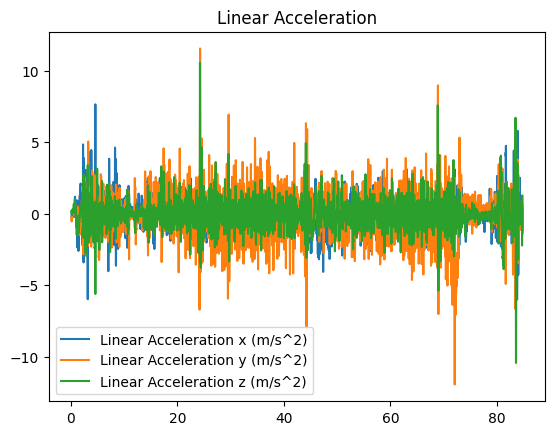

In [8]:
# plot all the sensor data in the specified directory

csv_files = get_csv_files(os.path.join(data_dir, data_files[0]))

for csv_file in csv_files:
    plot_sensor_data(csv_file)

## Kalman filter

Splitting runs recorded in a single take

In [10]:
from Python3Code.Chapter3.KalmanFilters import KalmanFilters

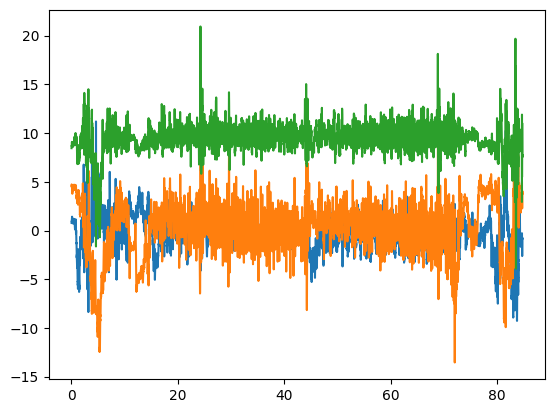

In [21]:
# apply kalman filter to the accelerometer data

accelerometer = pd.read_csv(os.path.join(data_dir, data_files[0], 'Accelerometer.csv'))

time_col = 'Time (s)'

value_col = accelerometer.columns[1:]

for col in value_col:
    kalman_filter = KalmanFilters()
    new_accelerometer = kalman_filter.apply_kalman_filter(accelerometer, col)
    plt.plot(accelerometer[time_col], new_accelerometer[col +'_kalman'], label=col)

In [22]:
new_accelerometer.head()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Acceleration x (m/s^2)_kalman,Acceleration y (m/s^2)_kalman,Acceleration z (m/s^2)_kalman
0,0.016886,0.800997,4.600202,8.577073,0.794807,4.548077,8.448872
1,0.018970,0.820140,4.619344,8.586644,0.810706,4.597693,8.541868
2,0.021054,0.844068,4.648058,8.600403,0.832973,4.634103,8.583287
3,0.023138,0.877568,4.671388,8.585447,0.862930,4.661134,8.584822
4,0.025222,0.867996,4.676772,8.595019,0.866336,4.672473,8.592068


In [23]:
accelerometer.head()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Acceleration x (m/s^2)_kalman,Acceleration y (m/s^2)_kalman,Acceleration z (m/s^2)_kalman
0,0.016886,0.800997,4.600202,8.577073,0.794807,4.548077,8.448872
1,0.018970,0.820140,4.619344,8.586644,0.810706,4.597693,8.541868
2,0.021054,0.844068,4.648058,8.600403,0.832973,4.634103,8.583287
3,0.023138,0.877568,4.671388,8.585447,0.862930,4.661134,8.584822
4,0.025222,0.867996,4.676772,8.595019,0.866336,4.672473,8.592068


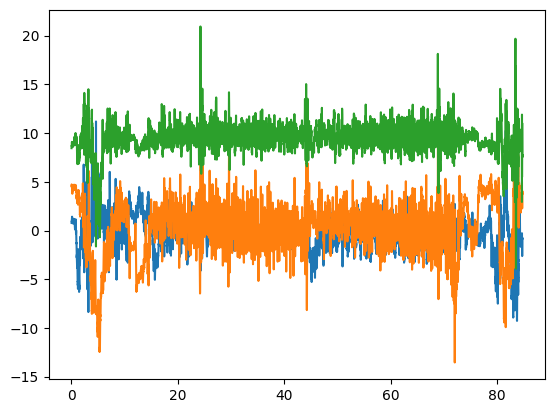

In [16]:
for col in value_col:
    plt.plot(accelerometer[time_col], accelerometer[col +'_kalman'], label=col)

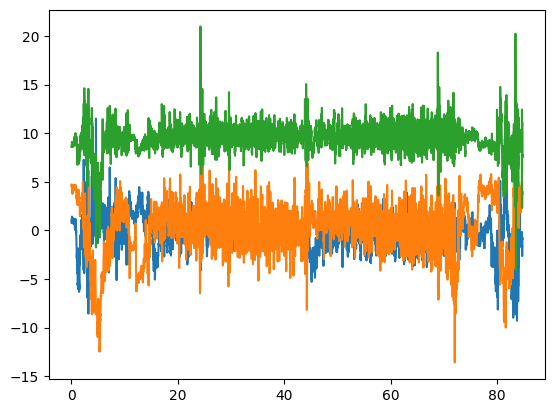

In [17]:
for col in value_col:
    plt.plot(accelerometer[time_col], accelerometer[col], label=col)

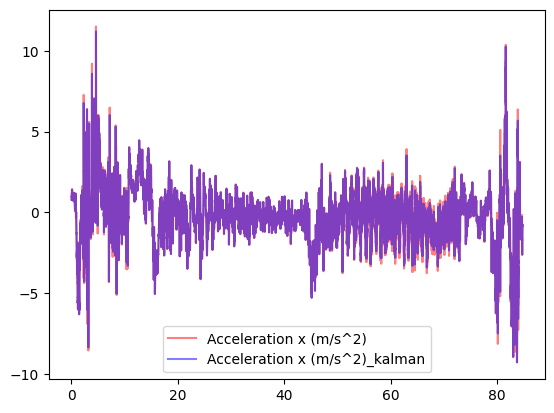

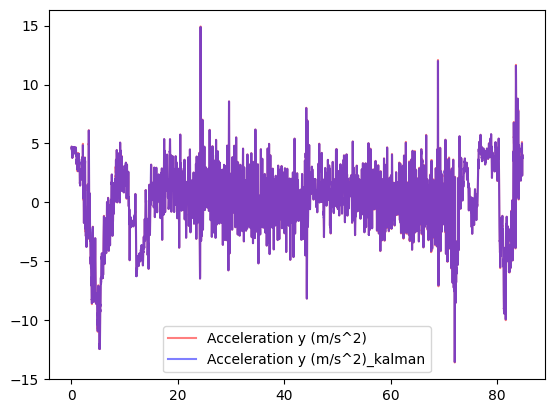

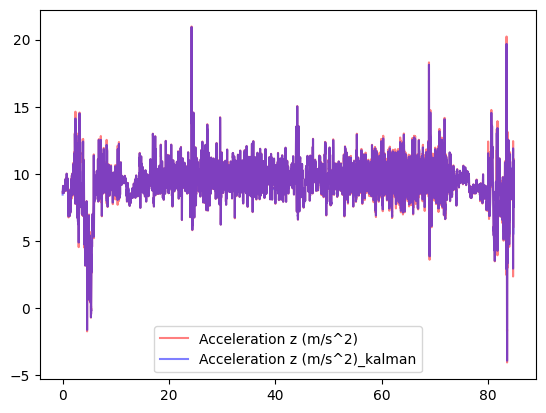

In [20]:
for col in value_col:
    # compare the original and filtered data

    plt.plot(accelerometer[time_col], accelerometer[col], label=col, alpha=0.5, color='red')
    plt.plot(accelerometer[time_col], accelerometer[col + '_kalman'], label=col + '_kalman',   alpha=0.5, color='blue')

    plt.legend()

    plt.show()

In [15]:
accelerometer.columns[1:]

Index(['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)',
       'Acceleration z (m/s^2)', 'Acceleration x (m/s^2)_kalman',
       'Acceleration y (m/s^2)_kalman', 'Acceleration z (m/s^2)_kalman'],
      dtype='object')

In [14]:
accelerometer.head()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Acceleration x (m/s^2)_kalman,Acceleration y (m/s^2)_kalman,Acceleration z (m/s^2)_kalman
0,0.016886,0.800997,4.600202,8.577073,0.794807,4.548077,8.448872
1,0.018970,0.820140,4.619344,8.586644,0.810706,4.597693,8.541868
2,0.021054,0.844068,4.648058,8.600403,0.832973,4.634103,8.583287
3,0.023138,0.877568,4.671388,8.585447,0.862930,4.661134,8.584822
4,0.025222,0.867996,4.676772,8.595019,0.866336,4.672473,8.592068


## Joining the dataset

In [19]:


import pandas as pd
import numpy as np
import re
import copy
from datetime import datetime, timedelta
import matplotlib.pyplot as plot
import matplotlib.dates as md


class DatasetGenerator:

    def __init__(self, base_dir, granularity):

        self.base_dir = base_dir
        self.granularity = granularity
        self.melted_data = None
        self.data = None

    def get_directories(self):

        # get all the directories inside the data directory

        data_files = os.listdir(self.base_dir)

        return data_files

    @classmethod
    def get_csv_files(self, dir_path):

        csv_files = os.listdir(dir_path)
        csv_files = [os.path.join(dir_path, f) for f in csv_files if f.endswith('.csv')]

        # turn them into dataframes

        sensor_dfs = [pd.read_csv(f) for f in csv_files]
        return sensor_dfs
    
    # melt the dataframes and merge them into a single dataframe
    @classmethod
    def melt_data(self, sensor_dfs, run_number, path_name, participant_name, body_part):
        """
        Melt the dataframes and merge them into a single dataframe

        Parameters
        ----------
        sensor_dfs: list
            List of dataframes
        run_number: int
            Run number
        path_name: str
            The name of the path run with the bike by the participant
        participant_name: str
            Name of the participant
        body_part: str
            Body part on which the sensors are attached

        Returns
        -------
        pd.DataFrame
            Melted dataframe with information about the run, participant, body part, and sensor data on each row
        """

        melted_dfs = []

        for i, df in enumerate(sensor_dfs):

            # melt the dataframe

            melted_df = pd.melt(df, id_vars=['Time (s)'], var_name='Sensor', value_name='Value')

            # add the run number, path name, participant name, and body part

            melted_df['Run'] = run_number
            melted_df['Path'] = path_name
            melted_df['Participant'] = participant_name
            melted_df['BodyPart'] = body_part

            melted_dfs.append(melted_df)

        melted_data = pd.concat(melted_dfs)

        return melted_data
    
    # melt from directory, the name of the directory is in the format [Name]_[Path]_[Repetition num]_[Body part]
    def melt_from_directory(self, dir_path):

        # get the name of the participant, path, repetition number, and body part

        dir_name = os.path.basename(dir_path)

        participant_name, path_name, run_number, body_part = dir_name.split('_')

        run_number = int(run_number)

        body_part = body_part.split(' ')[0].lower()

        assert body_part in ['head','leg'], f'Invalid body part{body_part} for participant {participant_name} , path {path_name} and run {run_number}\n DIR: {dir_path}\n'



        # get the sensor dataframes

        sensor_dfs = self.get_csv_files(dir_path)

        # melt the dataframes

        melted_data = self.melt_data(sensor_dfs, run_number, path_name, participant_name, body_part)

        return melted_data


    # aggregate the data based on the granularity    
    def aggregate_data(self, melted_data, features = ["mean", "min", "max", "median", "std", "count"]):
        """
        Aggregate the data based on the granularity

        Parameters
        ----------
        melted_data: pd.DataFrame
            Melted dataframe with information about the run, participant, body part, and sensor data on each row
        features: list
            List of features to compute for each sensor data

        Returns
        -------
        pd.DataFrame
            Aggregated dataframe with information about the run, participant, body part, and aggregated sensor data on each row
        """

        #assert that participant, run, and body part are the same for all the rows

        assert melted_data['Participant'].nunique() == 1, 'Multiple participants in the melted data'

        assert melted_data['Run'].nunique() == 1, 'Multiple runs in the melted data'

        # convert the time column to seconds
        melted_data['Time (s)'] = pd.to_datetime(melted_data['Time (s)'], unit='s')

        # create equallly spaced time intervals based on the granularity

        time_intervals = pd.date_range(melted_data['Time (s)'].min(), melted_data['Time (s)'].max(), freq=self.granularity)

        # create a new column with the time interval
        melted_data['Time Interval'] = pd.cut(melted_data['Time (s)'], time_intervals)

        # drop columns where time interval is null

        melted_data = melted_data.dropna(subset=['Time Interval'])

        grouped_data = melted_data.groupby(['Time Interval', 'BodyPart', 'Sensor']) # we are not grouping by run and participant because they are the same for all the rows

        # compute the features for each group
        aggregated_data = grouped_data.agg({'Value': features})

        # columns in the format [feature]_[sensor-name]
        aggregated_data = aggregated_data.pivot_table(index=['Time Interval', 'Run', 'Participant', 'BodyPart'], columns='Sensor', values='Value')

        # flatten the columns

        aggregated_data.columns = ['_'.join(col).strip() for col in aggregated_data.columns.values]

        # reset the index

        aggregated_data = aggregated_data.reset_index()

        # rename time interval to end time

        aggregated_data = aggregated_data.rename(columns={'Time Interval': 'End Time'})

        # convert the end time to the end of the interval

        aggregated_data['End Time'] = aggregated_data['End Time'].apply(lambda x: x.right)

        return aggregated_data
    
    # aggregate the data for the head and leg sensors at the same time, melting them separately and then aggregating them together
    
    def aggregate_couple (self, melted_data_head, melted_data_leg, features = ["mean", "min", "max", "median", "std", "count"]):


        melted_data = pd.concat([melted_data_leg, melted_data_head])

        # aggregate the data

        aggregated_data = self.aggregate_data(melted_data, features)

        # pivot the data on the body part

        aggregated_data = aggregated_data.pivot_table(index=['End Time', 'Run', 'Participant'], columns='BodyPart', values=aggregated_data.columns[4:])

        # flatten the columns

        aggregated_data.columns = ['_'.join(col).strip() for col in aggregated_data.columns.values]
        
        # reset the index

        aggregated_data = aggregated_data.reset_index()

        
        return aggregated_data
    

    def get_directories_pairs(self):
        """
        Get all the directories head-leg pairs in the data directory

        Returns
        -------
        list
            List of tuples with the directories of the head and leg sensors
        """
        
        directories_pairs = []

        # get all the directories

        original_dirs = self.get_directories()

        directories = [d.split(' ')[0].lower() for d in original_dirs] # removing the date

        # get the head and leg directories

        head_dirs = [d for d in directories if 'head' in d]

        leg_dirs = [d for d in directories if 'leg' in d]

        
        for head_dir in head_dirs:

            prefix = '_'.join(head_dir.split('_')[0:-1])

            # find the matching leg directory

            leg_dir = [d for d in leg_dirs if prefix in d]

            if len(leg_dir) == 0:

                print(f'No matching leg directory for {head_dir}')

                # append a directory with None for the leg

                

                directories_pairs.append((head_dir, None))

            elif len(leg_dir) == 1:

                # get the original directory name

                head_dir = [d for d in original_dirs if head_dir in d.lower()][0]

                assert head_dir is not None, f'No matching head directory for {head_dir}'

                assert len(head_dir) == 1, f'Multiple matching leg directories for {head_dir}: {leg_dir}'


                leg_dir = [d for d in original_dirs if leg_dir[0] in d.lower()][0]

                assert leg_dir is not None, f'No matching leg directory for {leg_dir}'

                assert len(leg_dir) == 1, f'Multiple matching head directories for {leg_dir}: {head_dir}'

                directories_pairs.append((head_dir, leg_dir[0]))



                leg_dirs.remove(leg_dir[0])

            else:

                raise ValueError(f'Multiple matching leg directories for {head_dir}: {leg_dir}\nThe prefix is {prefix} ')
            

        # append the remaining leg directories with None for the head

        for leg_dir in leg_dirs:

            #get the original directory name

            leg_dir = [d for d in original_dirs if leg_dir in d.lower()][0]

            assert leg_dir is not None, f'No matching leg directory for {leg_dir}'

            assert len(leg_dir) == 1, f'Multiple matching head directories for {leg_dir}: {head_dir}'



            directories_pairs.append((None, leg_dir))
            
        return directories_pairs





    
    # melt and aggregate the data over all the directories

    def melt_and_aggregate_data(self):
            
    
            # melt and aggregate the data for each directory
    
            aggregated_data = []

            melted_data = []
    
            directories_pairs = self.get_directories_pairs()

            for head_dir, leg_dir in directories_pairs:

                if head_dir is not None:

                    melted_data_head = self.melt_from_directory(os.path.join(self.base_dir, head_dir))

                    melted_data.append(melted_data_head)

                if leg_dir is not None:

                    melted_data_leg = self.melt_from_directory(os.path.join(self.base_dir, leg_dir))

                    melted_data.append(melted_data_leg)

                if head_dir is not None and leg_dir is not None:

                    aggregated_data_couple = self.aggregate_couple(melted_data_head, melted_data_leg)

                    aggregated_data.append(aggregated_data_couple)

                if head_dir is not None:

                    melted_data

                    aggregated_data_head = self.aggregate_data(melted_data_head)

                    aggregated_data.append(aggregated_data_head)

                if leg_dir is not None:

                    aggregated_data_leg = self.aggregate_data(melted_data_leg)

                    aggregated_data.append(aggregated_data_leg)

            # concatenate the melted and aggregated data

            melted_data = pd.concat(melted_data, axis=0, ignore_index= True)

            self.melted_data = melted_data

            aggregated_data = pd.concat(aggregated_data, axis=0, ignore_index=True)

            self.data = aggregated_data

            return aggregated_data
    

        
    





In [2]:
"head" in ["ds_1_leg", "he"]

False

In [119]:
dummy_df = pd.DataFrame({'Time (s)': [1, 2, 3, 4, 5], 'Accelerometer_X': [1, 2, 3, 4, 5], 'Accelerometer_Y': [1, 2, 3, 4, 5], 'Accelerometer_Z': [1, 2, 3, 4, 5]})

dummy_df_without_accelZ = pd.DataFrame({'Time (s)': [6, 7, 8, 9, 10], 'Accelerometer_X': [1, 2, 3, 4, 5], 'Accelerometer_Y': [1, 2, 3, 4, 5]})

# concat the two dataframes along axis 0 filling the miissing column with NaN

pd.concat([dummy_df, dummy_df_without_accelZ], axis=0, ignore_index=True)


,Time (s),Accelerometer_X,Accelerometer_Y,Accelerometer_Z
0,1,1,1,1.0
1,2,2,2,2.0
2,3,3,3,3.0
3,4,4,4,4.0
4,5,5,5,5.0
5,6,1,1,NaN
6,7,2,2,NaN
7,8,3,3,NaN
8,9,4,4,NaN
9,10,5,5,NaN


### Testing

In [128]:
'_'.join("head_dir_dslks_dkja".split('_')[0:-1])

'head_dir_dslks'

In [ ]:
# list of strings 

list_of_str = ['head_dir_dslks_dkja', 'leg_dir_dslks_dkja', 'head_dir_dslks_dkja', 'leg_dir_dslks_dkja']

# join the strings in the list

''.join(list_of_str)



In [52]:
rng_tz = pd.DatetimeIndex(["2021-10-31 03:30:00", "2021-10-31 05:30:00"], tz="Europe/Amsterdam")

rng_tz.floor("2")


In [113]:
generator = DatasetGenerator(base_dir='data', granularity='1s')

data_files = generator.get_directories()

data_files

['Julian_straight_2_head 2024-06-07 14-10-08',
 'Paul_circle_1_head 2024-06-07 13-51-26',
 'Dany_circle_14_head 2024-06-07 15-27-29',
 'Julian_straight_1_leg 2024-06-07 14-06-42',
 'Mark_straight_14_head 15-42-49',
 'Michele_circle_14_head 2024-06-07 15-54-09',
 'Julian_straight_4_leg 2024-06-07 14-14-51',
 '.DS_Store',
 'Julian_circle_14_leg 2024-06-07 15-30-46',
 'Paul_straight_1_leg 2024-06-07 13-40-28',
 'Paul_circle_4_leg 2024-06-07 13-58-19',
 'Martin_straight_14_leg 2024-06-07 14-42-51',
 'Julian_circle_14_head 2024-06-07 15-30-43',
 'Dany_straight_14_leg 2024-06-07 15-22-52',
 'Michele_straight_14_leg 2024-06-07 14-56-15',
 'Paul_circle_4_head 2024-06-07 13-58-23',
 'Martin_straight_14_leg 2024-06-07 14-42-51.zip',
 'Dany_circle_14_leg 2024-06-07 15-27-49',
 'Paul_straight_2_head 2024-06-07 13-45-59',
 'Martin_circle_14_leg 2024-06-07 14-47-32',
 'Paul_straight_2_leg 2024-06-07 13-46-08',
 'Mark_circle_14_head 2024-06-07 15-47-53',
 'Felix_circle_14_head 2024-06-07 15-11-05',
 

In [114]:
# melt the first directory

melted_data = generator.melt_from_directory(os.path.join(generator.base_dir, data_files[0]))

In [85]:
melted_data

,Time (s),Sensor,Value,Run,Path,Participant,BodyPart
0,1970-01-01 00:00:00.093088396,Distance (cm),5.000000,2,straight,Julian,head
0,1970-01-01 00:00:00.000000000,Illuminance (lx),6796.897461,2,straight,Julian,head
1,1970-01-01 00:00:02.583698113,Illuminance (lx),13925.833010,2,straight,Julian,head
2,1970-01-01 00:00:05.124472580,Illuminance (lx),11944.293950,2,straight,Julian,head
3,1970-01-01 00:00:05.279809890,Illuminance (lx),10401.616210,2,straight,Julian,head
...,...,...,...,...,...,...,...
14920,1970-01-01 00:01:24.686068860,Linear Acceleration z (m/s^2),-2.219433,2,straight,Julian,head
14921,1970-01-01 00:01:24.703059890,Linear Acceleration z (m/s^2),-0.160688,2,straight,Julian,head
14922,1970-01-01 00:01:24.720055490,Linear Acceleration z (m/s^2),1.294378,2,straight,Julian,head
14923,1970-01-01 00:01:24.737065820,Linear Acceleration z (m/s^2),0.075890,2,straight,Julian,head


In [92]:
# create a range between the min and max time

time_intervals = np.arange(melted_data['Time (s)'].min(), melted_data['Time (s)'].max(), 1)

In [93]:
time_intervals

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84.])

In [76]:
time_intervals

range(0, 84)

In [94]:
melted_data['Time Interval'] = pd.cut(melted_data['Time (s)'], time_intervals)

In [95]:
# get row where time interval is nan

melted_data[melted_data['Time Interval'].isna()]

,Time (s),Sensor,Value,Run,Path,Participant,BodyPart,Time Interval
0,0.000000,Illuminance (lx),6796.897461,2,straight,Julian,head,NaN
68,84.157363,Illuminance (lx),20597.675780,2,straight,Julian,head,NaN
69,84.570772,Illuminance (lx),23010.001950,2,straight,Julian,head,NaN
70,84.734471,Illuminance (lx),25833.853520,2,straight,Julian,head,NaN
8396,84.003160,Magnetic field x (µT),-13.798200,2,straight,Julian,head,NaN
...,...,...,...,...,...,...,...,...
14920,84.686069,Linear Acceleration z (m/s^2),-2.219433,2,straight,Julian,head,NaN
14921,84.703060,Linear Acceleration z (m/s^2),-0.160688,2,straight,Julian,head,NaN
14922,84.720055,Linear Acceleration z (m/s^2),1.294378,2,straight,Julian,head,NaN
14923,84.737066,Linear Acceleration z (m/s^2),0.075890,2,straight,Julian,head,NaN


In [86]:
melted_data['Time (s)'] = pd.to_datetime(melted_data['Time (s)'], unit='s')
time_intervals = pd.date_range(melted_data['Time (s)'].min(), melted_data['Time (s)'].max(), freq='1s')

# create a new column with the time interval

melted_data['Time Interval'] = pd.cut(melted_data['Time (s)'], time_intervals)

In [88]:

melted_data [melted_data['Time Interval'].isna()]   

,Time (s),Sensor,Value,Run,Path,Participant,BodyPart,Time Interval
0,1970-01-01 00:00:00.000000000,Illuminance (lx),6796.897461,2,straight,Julian,head,NaN
68,1970-01-01 00:01:24.157363380,Illuminance (lx),20597.675780,2,straight,Julian,head,NaN
69,1970-01-01 00:01:24.570772210,Illuminance (lx),23010.001950,2,straight,Julian,head,NaN
70,1970-01-01 00:01:24.734471330,Illuminance (lx),25833.853520,2,straight,Julian,head,NaN
8396,1970-01-01 00:01:24.003160190,Magnetic field x (µT),-13.798200,2,straight,Julian,head,NaN
...,...,...,...,...,...,...,...,...
14920,1970-01-01 00:01:24.686068860,Linear Acceleration z (m/s^2),-2.219433,2,straight,Julian,head,NaN
14921,1970-01-01 00:01:24.703059890,Linear Acceleration z (m/s^2),-0.160688,2,straight,Julian,head,NaN
14922,1970-01-01 00:01:24.720055490,Linear Acceleration z (m/s^2),1.294378,2,straight,Julian,head,NaN
14923,1970-01-01 00:01:24.737065820,Linear Acceleration z (m/s^2),0.075890,2,straight,Julian,head,NaN


In [115]:

# aggregate the data

aggregated_data = generator.aggregate_data(melted_data)

In [116]:
aggregated_data

,End Time,Run,Participant,BodyPart,count_Acceleration x (m/s^2),count_Acceleration y (m/s^2),count_Acceleration z (m/s^2),count_Direction (°),count_Distance (cm),count_Gyroscope x (rad/s),...,std_Gyroscope y (rad/s),std_Gyroscope z (rad/s),std_Illuminance (lx),std_Linear Acceleration x (m/s^2),std_Linear Acceleration y (m/s^2),std_Linear Acceleration z (m/s^2),std_Magnetic field x (µT),std_Magnetic field y (µT),std_Magnetic field z (µT),std_Pressure (hPa)
0,1970-01-01 00:00:01,2,Julian,head,463.0,463.0,463.0,1.0,1.0,457.0,...,0.357018,0.135799,NaN,0.374316,0.274264,0.238321,92.105154,4.011371,15.215127,0.022193
1,1970-01-01 00:00:02,2,Julian,head,470.0,470.0,470.0,1.0,0.0,470.0,...,0.592484,0.233849,NaN,1.231524,0.447062,0.608375,2.369881,1.451109,2.221401,0.026878
2,1970-01-01 00:00:03,2,Julian,head,471.0,471.0,471.0,1.0,0.0,471.0,...,0.663135,0.479790,NaN,1.945943,1.197011,1.557861,3.998542,11.686932,3.623614,0.019390
3,1970-01-01 00:00:04,2,Julian,head,470.0,470.0,470.0,1.0,0.0,470.0,...,0.473276,0.752552,NaN,1.797618,1.697879,1.321446,2.437603,12.704810,6.636770,0.019901
4,1970-01-01 00:00:05,2,Julian,head,470.0,470.0,470.0,1.0,0.0,470.0,...,1.008097,0.927195,NaN,1.808321,1.245671,1.500442,5.516857,3.399578,8.515563,0.031049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,1970-01-01 00:01:20,2,Julian,head,470.0,470.0,470.0,1.0,0.0,470.0,...,0.349334,0.504235,NaN,0.759084,0.548372,0.310014,4.276104,1.255269,3.604351,0.021716
80,1970-01-01 00:01:21,2,Julian,head,471.0,471.0,471.0,1.0,0.0,471.0,...,0.561954,0.484747,NaN,0.971919,1.486859,1.665909,9.566981,12.853327,3.244789,0.029250
81,1970-01-01 00:01:22,2,Julian,head,470.0,470.0,470.0,1.0,0.0,470.0,...,0.428656,1.202751,NaN,1.472197,1.773823,1.704529,5.432850,4.341462,3.080275,0.042088
82,1970-01-01 00:01:23,2,Julian,head,470.0,470.0,470.0,1.0,0.0,470.0,...,0.367822,0.608278,NaN,0.839122,1.170994,0.953544,4.673039,11.075968,1.559277,0.028172


### Generating whole dataset

In [20]:
generator = DatasetGenerator(base_dir='data', granularity='1s')

In [21]:
generator.get_directories_pairs()

No matching leg directory for julian_straight_2_head


AssertionError: Multiple matching leg directories for Paul_circle_1_head 2024-06-07 13-51-26: ['paul_circle_1_leg']

In [15]:
# generate the data for all the directories

generator = DatasetGenerator(base_dir='data', granularity='1s')

aggregated_data = generator.melt_and_aggregate_data()

No matching leg directory for julian_straight_2_head


FileNotFoundError: [Errno 2] No such file or directory: 'data/julian_straight_2_head'